# Synthetic Artifacts

In [3]:
import matplotlib.pyplot as p
import xarray as xr

import cedalion
import cedalion.datasets as datasets
import cedalion.nirs
import cedalion.sim.synthetic_artifact as sa

First, we'll load some example data.

Magnitude,[[[0.040420720851589244 0.04460046098449573 0.0442158667266921 ... 0.010876348689028297 0.01189058853204466 0.006847636450666034] [0.023820496835156947 0.020076986081598715 0.03480909472899116 ... 0.023992850639162802 0.027040875264083337 0.031732993935654014]] [[-0.008280063468686781 -0.01784405593180633 -0.002198739340328898 ... -0.003592058220542012 -0.006742726672860488 -0.0047443982578777594] [-0.03725579234490354 -0.04067296052603699 -0.028261149412724014 ... 0.008275386235838757 0.005771141488662178 0.0051515177576299375]] [[0.1005582275517943 0.09914287354277777 0.11119025710690507 ... -0.02830701101541003 -0.023242770227372977 -0.023590421283804962] [0.04993799639529682 0.047551763623795935 0.06016311306879892 ... -0.005456229532249399 -0.0015308884573803712 -0.004733085331725723]] ... [[0.09543410489184105 0.11098678842280141 0.10684828479073327 ... -0.038599718102985896 -0.03566192105523218 -0.04378947818067423] [0.03858010875753767 0.06286432773409747 0.06128249638988582 ... 0.008314104856099373 0.007674359302522161 -0.0026751405572218796]] [[0.15506580435158798 0.17214467649471782 0.16880746748060918 ... -0.06854981498765861 -0.06838218329243445 -0.07333574448986935] [0.10250044669095155 0.12616269025036977 0.1261907782199553 ... -0.040611038136814874 -0.040371126750177955 -0.04750589562552556]] [[0.0580532188103781 0.06125157285758024 0.06083507429037254 ... -0.019157798285875216 -0.019003174994086804 -0.020343916456372766] [0.024377017778147235 0.030886638430615728 0.03219054575814673 ... -0.01108594305570406 -0.010936510768482734 -0.013167265399560904]]]
Units,dimensionless


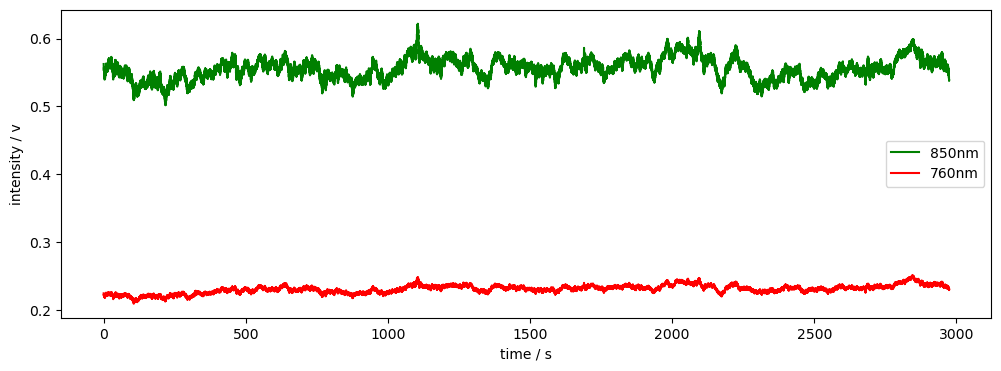

In [4]:
rec = datasets.get_fingertapping()
rec["od"] = cedalion.nirs.int2od(rec["amp"])

f, ax = p.subplots(1, 1, figsize=(12, 4))
ax.plot(
    rec["amp"].time,
    rec["amp"].sel(channel="S3D3", wavelength="850"),
    "g-",
    label="850nm",
)
ax.plot(
    rec["amp"].time,
    rec["amp"].sel(channel="S3D3", wavelength="760"),
    "r-",
    label="760nm",
)
p.legend()
ax.set_xlabel("time / s")
ax.set_ylabel("intensity / v")

display(rec["od"])

## Artifact Generation

Artifacts are generated by functions taking as arguments: 
- time axis of timeseries 
- onset time 
- duration

To enable proper scaling, the amplitude of the generic artifact generated by these functions should be 1.

<xarray.DataArray 'time' (time: 23239)> Size: 186kB
array([0., 0., 0., ..., 1., 1., 1.])
Coordinates:
  * time     (time) float64 186kB 0.0 0.128 0.256 ... 2.974e+03 2.974e+03

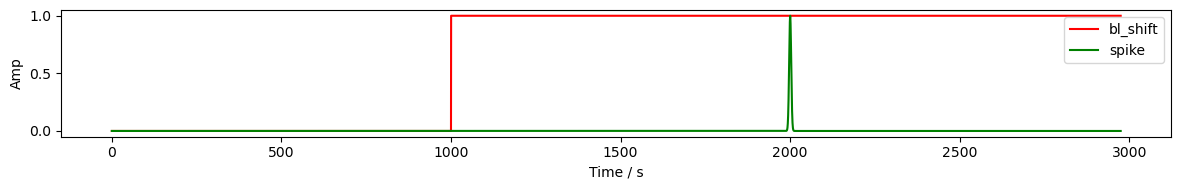

In [6]:
time = rec["amp"].time

sample_bl_shift = sa.gen_bl_shift(time, 1000)
sample_spike = sa.gen_spike(time, 2000, 3)

display(sample_bl_shift)

fig, ax =  p.subplots(1, 1, figsize=(12,2))
ax.plot(time, sample_bl_shift, "r-", label="bl_shift")
ax.plot(time, sample_spike, "g-", label="spike")
ax.set_xlabel('Time / s')
ax.set_ylabel('Amp')
ax.legend()

p.tight_layout()
p.show()

## Controlling Artifact Timing

Artifacts can be placed using a timing dataframe with columns onset_time, duration, trial_type, value, and channel (extends stim dataframe).

We can use the function add_event_timing to create and modify timing dataframes. The function allows precise control over each event.

The function sel_chans_by_opt allows us to select a list of channels by way of a list of optodes. This reflects the fact that motion artifacts usually stem from the motion of a specific optode or set of optodes, which in turn affects all related channels.

We can also use the functions random_events_num and random_events_perc to add random events to the dataframe—specifying either the number of events or the percentage of the timeseries duration, respectively.

In [8]:
# Create a list of events in the format (onset, duration)
events = [(1000, 1), (2000, 1)]

# Creates a new timing dataframe with the specified events.
# Setting channel to None indicates that the artifact applies to all channels.
timing_amp = sa.add_event_timing(events, 'bl_shift', None)

# Select channels by optode
chans = sa.sel_chans_by_opt(["S1"], rec["od"])

# Add random events to the timing dataframe
timing_od = sa.random_events_perc(time, 0.01, ["spike"], chans)

display(timing_amp)
display(timing_od)

,onset,duration,trial_type,value,channel
0,1000,1,bl_shift,1,None
1,2000,1,bl_shift,1,None


,onset,duration,trial_type,value,channel
0,2964.586569,0.146121,spike,1,"[S1D1, S1D2, S1D3, S1D9]"
1,478.973028,0.308084,spike,1,"[S1D1, S1D2, S1D3, S1D9]"
2,1764.962859,0.340963,spike,1,"[S1D1, S1D2, S1D3, S1D9]"
3,1881.319227,0.215160,spike,1,"[S1D1, S1D2, S1D3, S1D9]"
4,1247.744432,0.127334,spike,1,"[S1D1, S1D2, S1D3, S1D9]"
...,...,...,...,...,...
111,148.682777,0.394007,spike,1,"[S1D1, S1D2, S1D3, S1D9]"
112,920.914544,0.227834,spike,1,"[S1D1, S1D2, S1D3, S1D9]"
113,462.375420,0.367011,spike,1,"[S1D1, S1D2, S1D3, S1D9]"
114,1948.896593,0.302741,spike,1,"[S1D1, S1D2, S1D3, S1D9]"


## Adding Artifacts to Data

The function add_artifacts automatically scales artifacts and adds them to timeseries data. The function takes arguments
- ts: cdt.NDTimeSeries
- timing: pd.DataFrame
- artifacts: Dict
- (mode): 'auto' (default) or 'manual'
- (scale): float = 1
- (window_size): float = 120s

The artifact functions (see above) are passed as a dictionary. Keys correspond to entries in the column trial_type of the timing dataframe, i.e. each event specified in the timing dataframe is generated using the function artifacts[trial_type]. If mode is 'manual', artifacts are scaled directly by the scale parameter, otherwise artifacts are automatically scaled by a parameter alpha which is calculated using a sliding window approach.

If we want to auto scale based on concentration amplitudes but to add the artifacts to OD data, we can use the function add_chromo_artifacts_2_od. The function requires slightly different arguments because of the conversion between OD and conc:
- ts: cdt.NDTimeSeries
- timing: pd.DataFrame
- artifacts: Dict
- dpf: differential pathlength factor
- geo3d: geometry of optodes (see recording object description)
- (scale)
- (window_size)


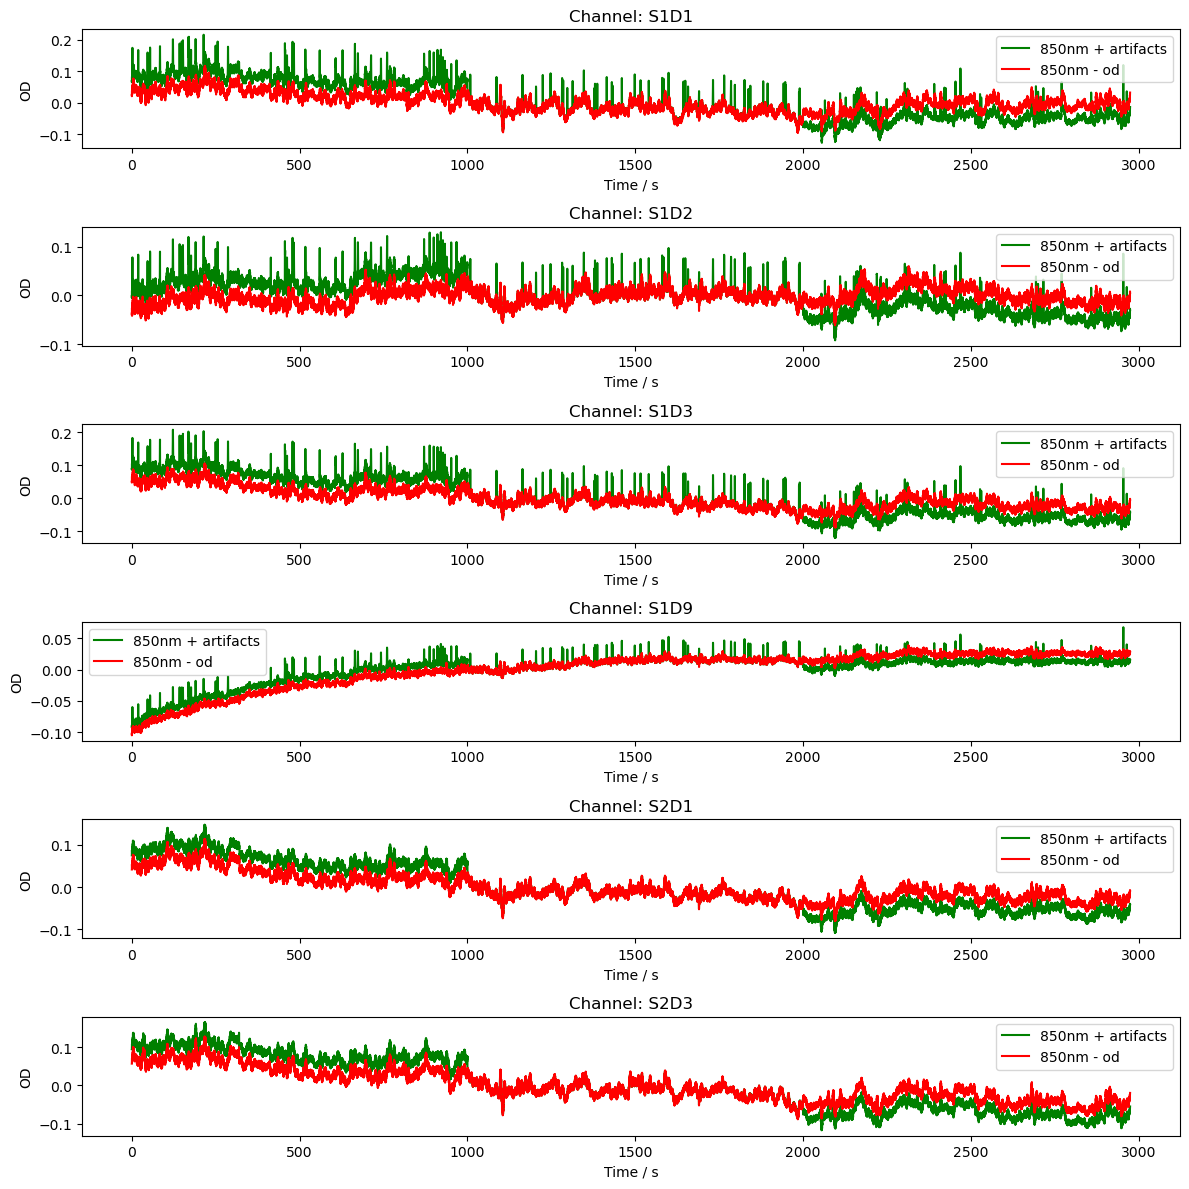

In [11]:
artifacts = {"spike": sa.gen_spike, "bl_shift": sa.gen_bl_shift}

# Add baseline shifts to the amp data
rec["amp2"] = sa.add_artifacts(rec["amp"], timing_amp, artifacts)

# Convert the amp data to optical density
rec["od2"] = cedalion.nirs.int2od(rec["amp2"])

dpf = xr.DataArray(
    [6, 6],
    dims="wavelength",
    coords={"wavelength": rec["amp"].wavelength},
)

# add spikes to od based on conc amplitudes
rec["od2"] = sa.add_chromo_artifacts_2_od(
    rec["od2"], timing_od, artifacts, rec.geo3d, dpf, 1.5
)

# Plot the OD data
channels = rec["od"].channel.values[0:6]
fig, axes = p.subplots(len(channels), 1, figsize=(12, len(channels) * 2))
if len(channels) == 1:
    axes = [axes]
for i, channel in enumerate(channels):
    ax = axes[i]
    ax.plot(
        rec["od2"].time,
        rec["od2"].sel(channel=channel, wavelength="850"),
        "g-",
        label="850nm + artifacts",
    )
    ax.plot(
        rec["od"].time,
        rec["od"].sel(channel=channel, wavelength="850"),
        "r-",
        label="850nm - od",
    )
    ax.set_title(f"Channel: {channel}")
    ax.set_xlabel("Time / s")
    ax.set_ylabel("OD")
    ax.legend()
p.tight_layout()
p.show()

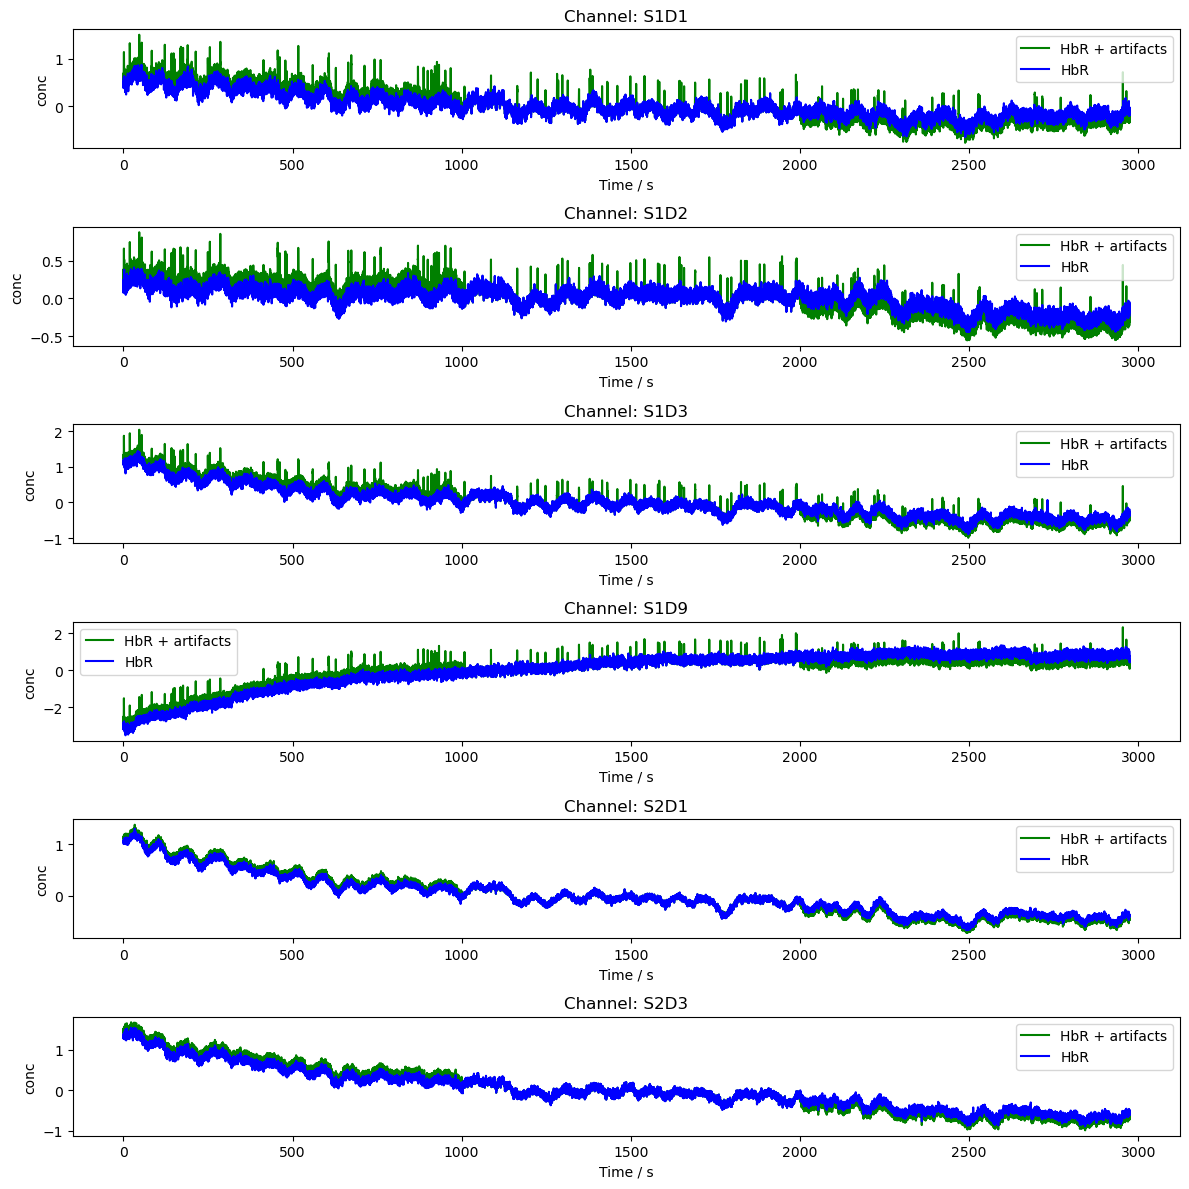

In [12]:
# Plot the data in conc

rec["conc"] = cedalion.nirs.od2conc(rec["od"], rec.geo3d, dpf)
rec["conc2"] = cedalion.nirs.od2conc(rec["od2"], rec.geo3d, dpf)
channels = rec["od"].channel.values[0:6]
fig, axes = p.subplots(len(channels), 1, figsize=(12, len(channels) * 2))
if len(channels) == 1:
    axes = [axes]
for i, channel in enumerate(channels):
    ax = axes[i]
    ax.plot(
        rec["conc2"].time,
        rec["conc2"].sel(channel=channel, chromo="HbR"),
        "g-",
        label="HbR + artifacts",
    )
    ax.plot(
        rec["conc"].time,
        rec["conc"].sel(channel=channel, chromo="HbR"),
        "b-",
        label="HbR",
    )
    ax.set_title(f"Channel: {channel}")
    ax.set_xlabel("Time / s")
    ax.set_ylabel("conc")
    ax.legend()
p.tight_layout()
p.show()

## Problems, improvements

- One-function wrapper/interface?
- More sophisticated artifacts (e.g. smooth baseline shift)